# Baseline N = 1 and only using location

In [12]:
import sys
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
sys.path.append(os.path.abspath('../src'))
from lib import (
    train_and_evaluate_models,
    create_eui_comparison_plots,
    evaluate_model_strategies,
    calculate_average_metrics,
    create_error_distribution_plots
)

In [14]:
output_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(output_path)
merged_df = merged_df.rename(columns={'total_year': 'hdd_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

#np.random.seed(123)
#merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

# Train / Test

In [15]:
train_test_split_original_data_path = "../data/03_processed/train_test_split_original_data.csv"
train_test_split_original_data = pd.read_csv(train_test_split_original_data_path)

train_test_split_new_data_path = "../data/03_processed/train_test_split_new_data.csv"
train_test_split_new_data = pd.read_csv(train_test_split_new_data_path)

train_test_split = pd.concat([train_test_split_original_data, train_test_split_new_data], ignore_index=True)

merged_df = merged_df.merge(train_test_split, on=['index', 'geonameid'], how='left')

# We want to keep original data 
merged_df = merged_df[merged_df["source"] == "World Bank CURB"]

In [16]:


features = [
    #"hdd_total_year", 
    #"cdd_total_year", 
    #"GDP_per_capita", 
    #"Urbanization_Rate_2022",
    #"latitude",
    #"longitude",  
    #"Paris_Agreement",
    #"Subnational HDI", 
    #"Educational index", 
    #"Income index",
    #"2m_temperature_2023_avg",
    #"2m_dewpoint_temperature_2023_avg",
    #"total_precipitation_2023",
    "longitude_sin", 
    "longitude_cos", 
    "latitude_sin", 
    "latitude_cos",  
    #"population_density"
]

feature_abbreviations = {
    #"hdd_total_year": "HDD",
    #"cdd_total_year": "CDD", 
    #"GDP_per_capita": "GDP",
    #"Urbanization_Rate_2022": "URB",
    #"latitude": "Lat",
    #"longitude": "Long",
    #"Paris_Agreement": "Paris",
    #"Subnational HDI": "HDI", 
    #"Educational index": "EDU" , 
    #"Income index": "Income",
    #"2m_temperature_2023_avg": "Temp",
    #"2m_dewpoint_temperature_2023_avg": "Dew",
    #"total_precipitation_2023": "Precip",
    "longitude_sin": "Long_Sin", 
    "longitude_cos": "Long_Cos", 
    "latitude_sin": "Lat_Sin", 
    "latitude_cos": "Lat_Cos",  
   #"population_density": "Pop_Dens"
}

target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']


# KNN

In [17]:
knn_params = {
    'n_neighbors': 1,          # number of neighbors
   # 'weights': 'distance',     # weight points by inverse of their distance
   # 'algorithm': 'auto',       # automatically choose the best algorithm
   # 'leaf_size': 30,          # leaf size for tree algorithms
   # 'p': 2,                   # power parameter for Minkowski metric (2 = Euclidean distance)
   # 'metric': 'minkowski',     # distance metric to use
   # 'n_jobs': -1              # use all available cores
}

### KNN - Within Domain

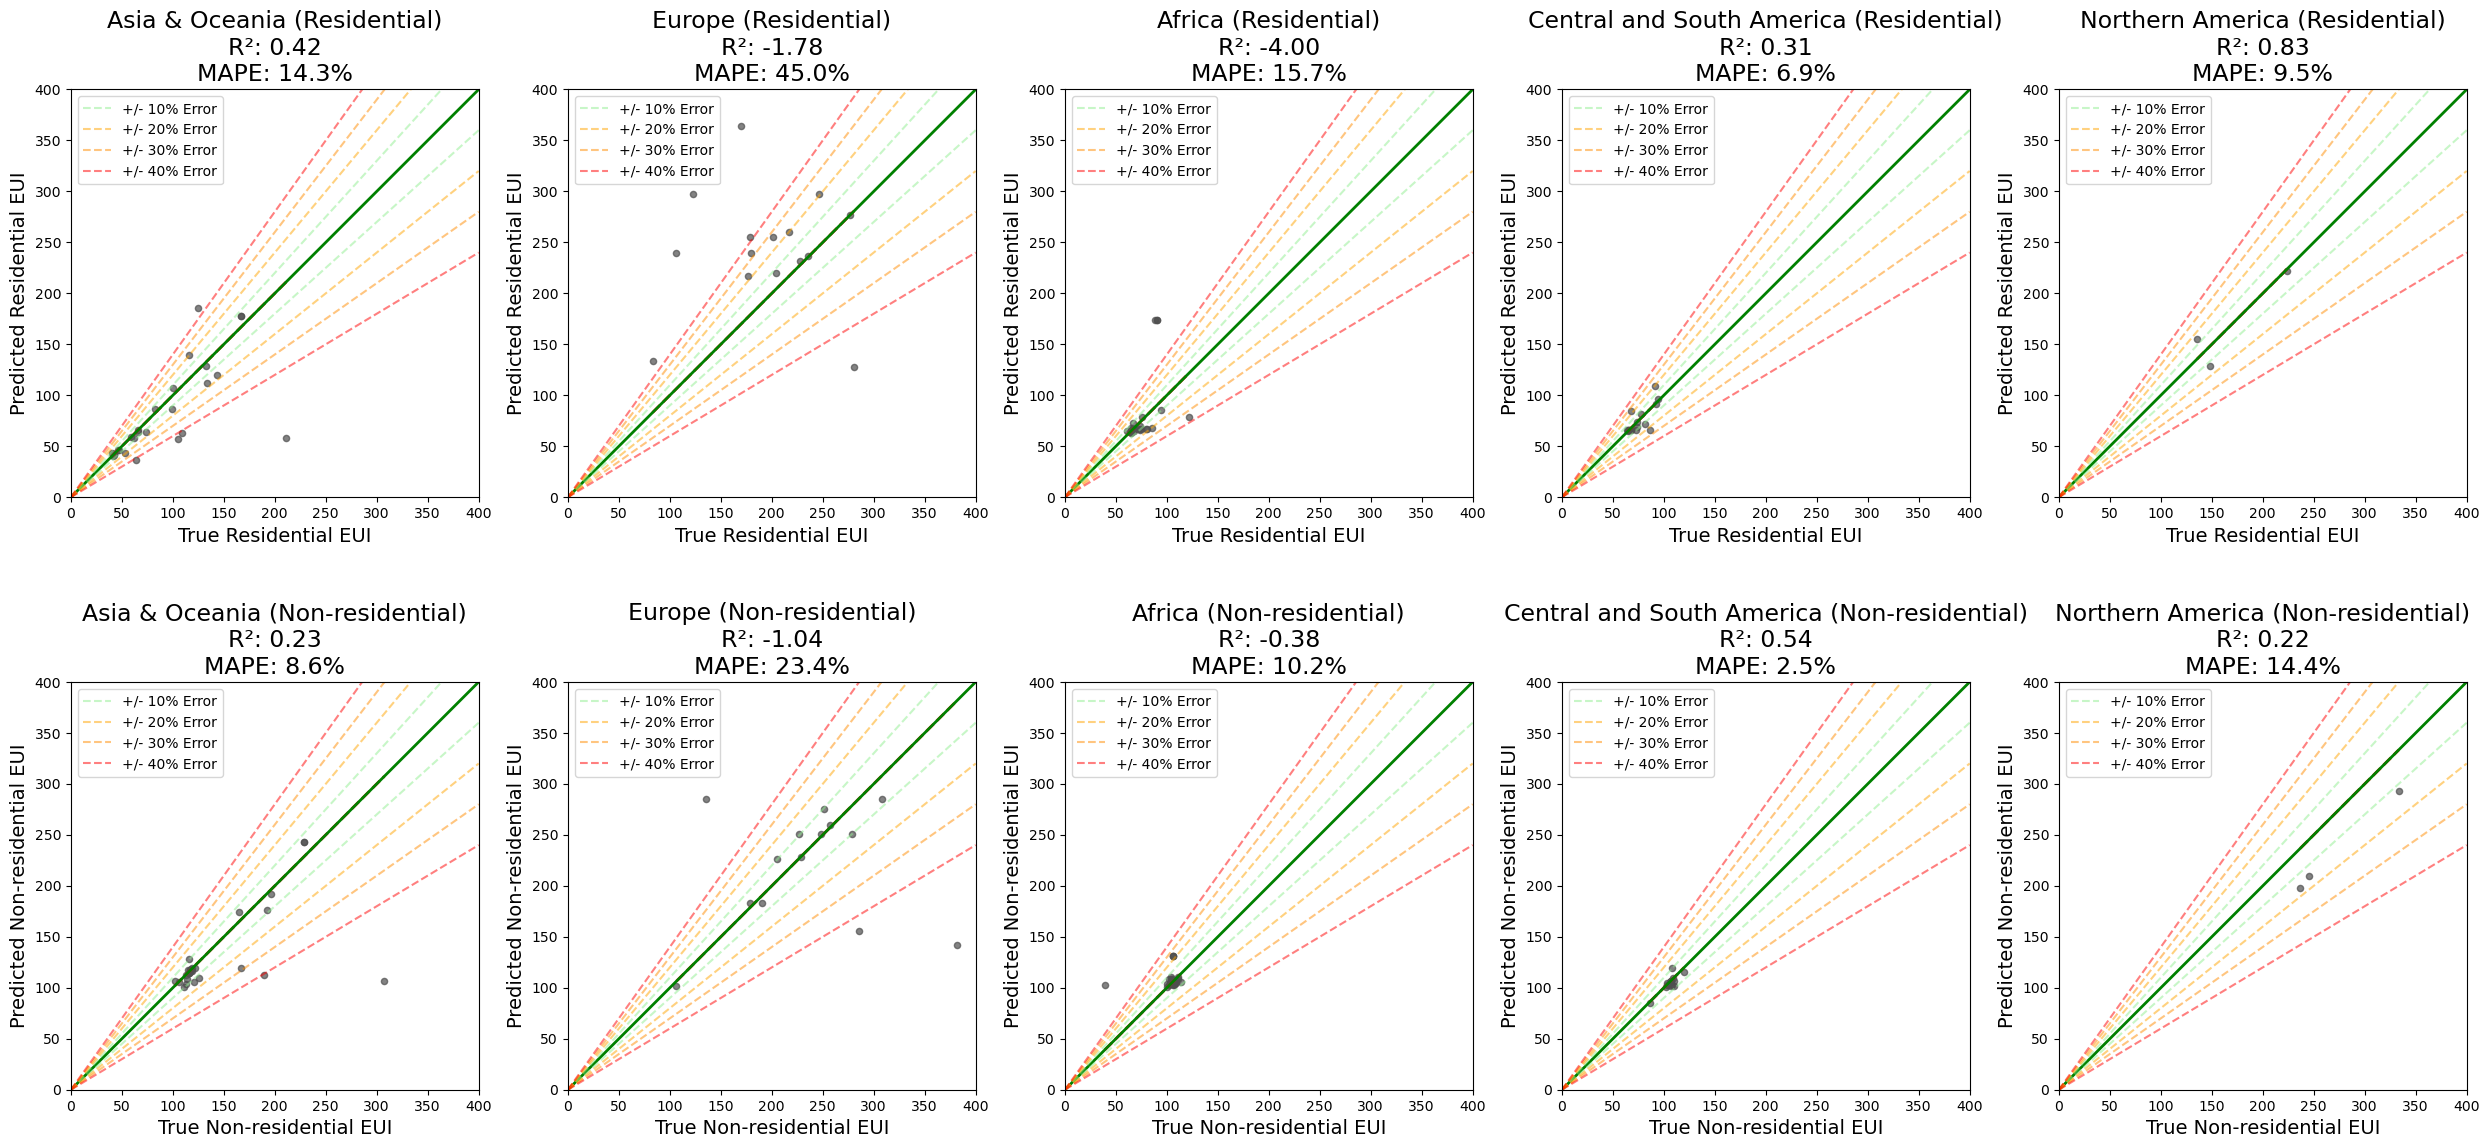

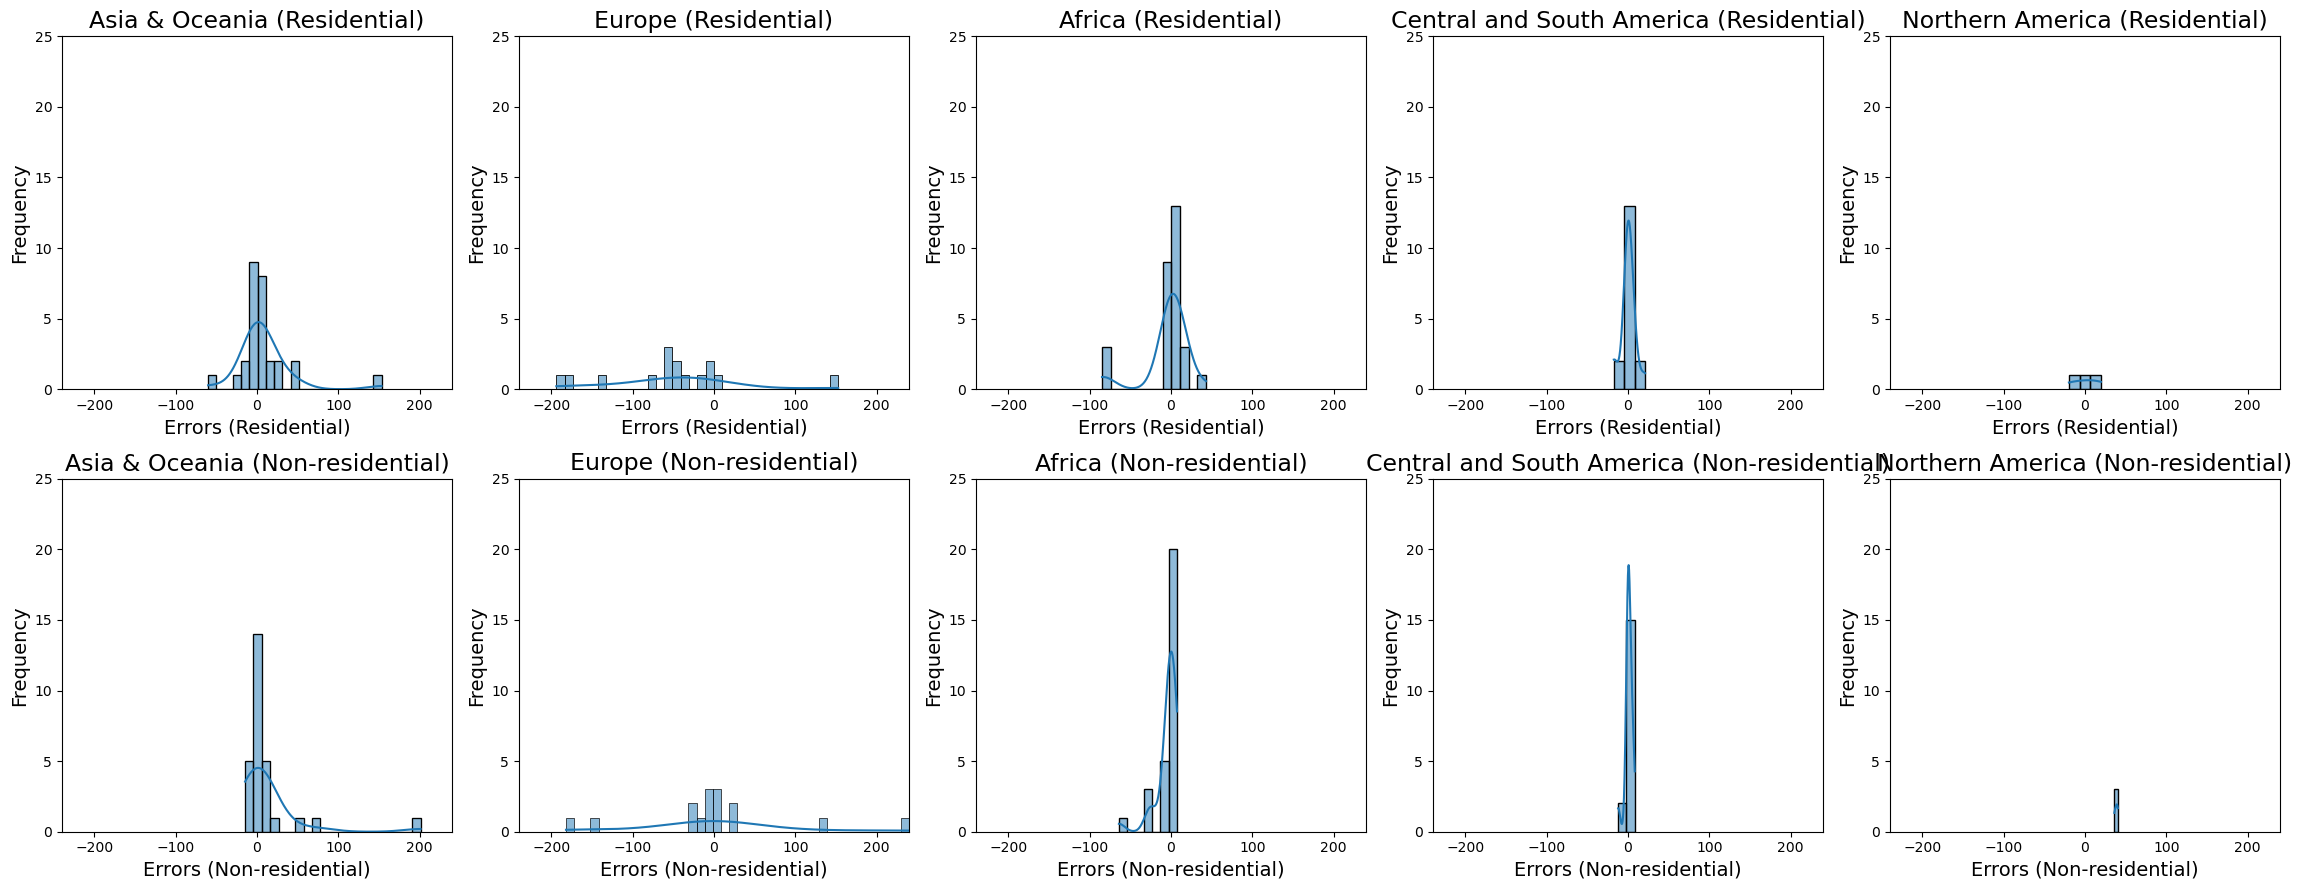

In [18]:
# Within-domain
model_knn_within = KNeighborsRegressor(**knn_params)
results_knn_within = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_knn_within,
    strategy='within_domain'
)

create_eui_comparison_plots(results_knn_within, 
    save_path='../figures/model_plots/knn_within_domain_eui_predictions.png')

create_error_distribution_plots(results_knn_within,
    save_path='../figures/model_plots/knn_within_domain_error_distribution.png')

KNN - Cross Domain

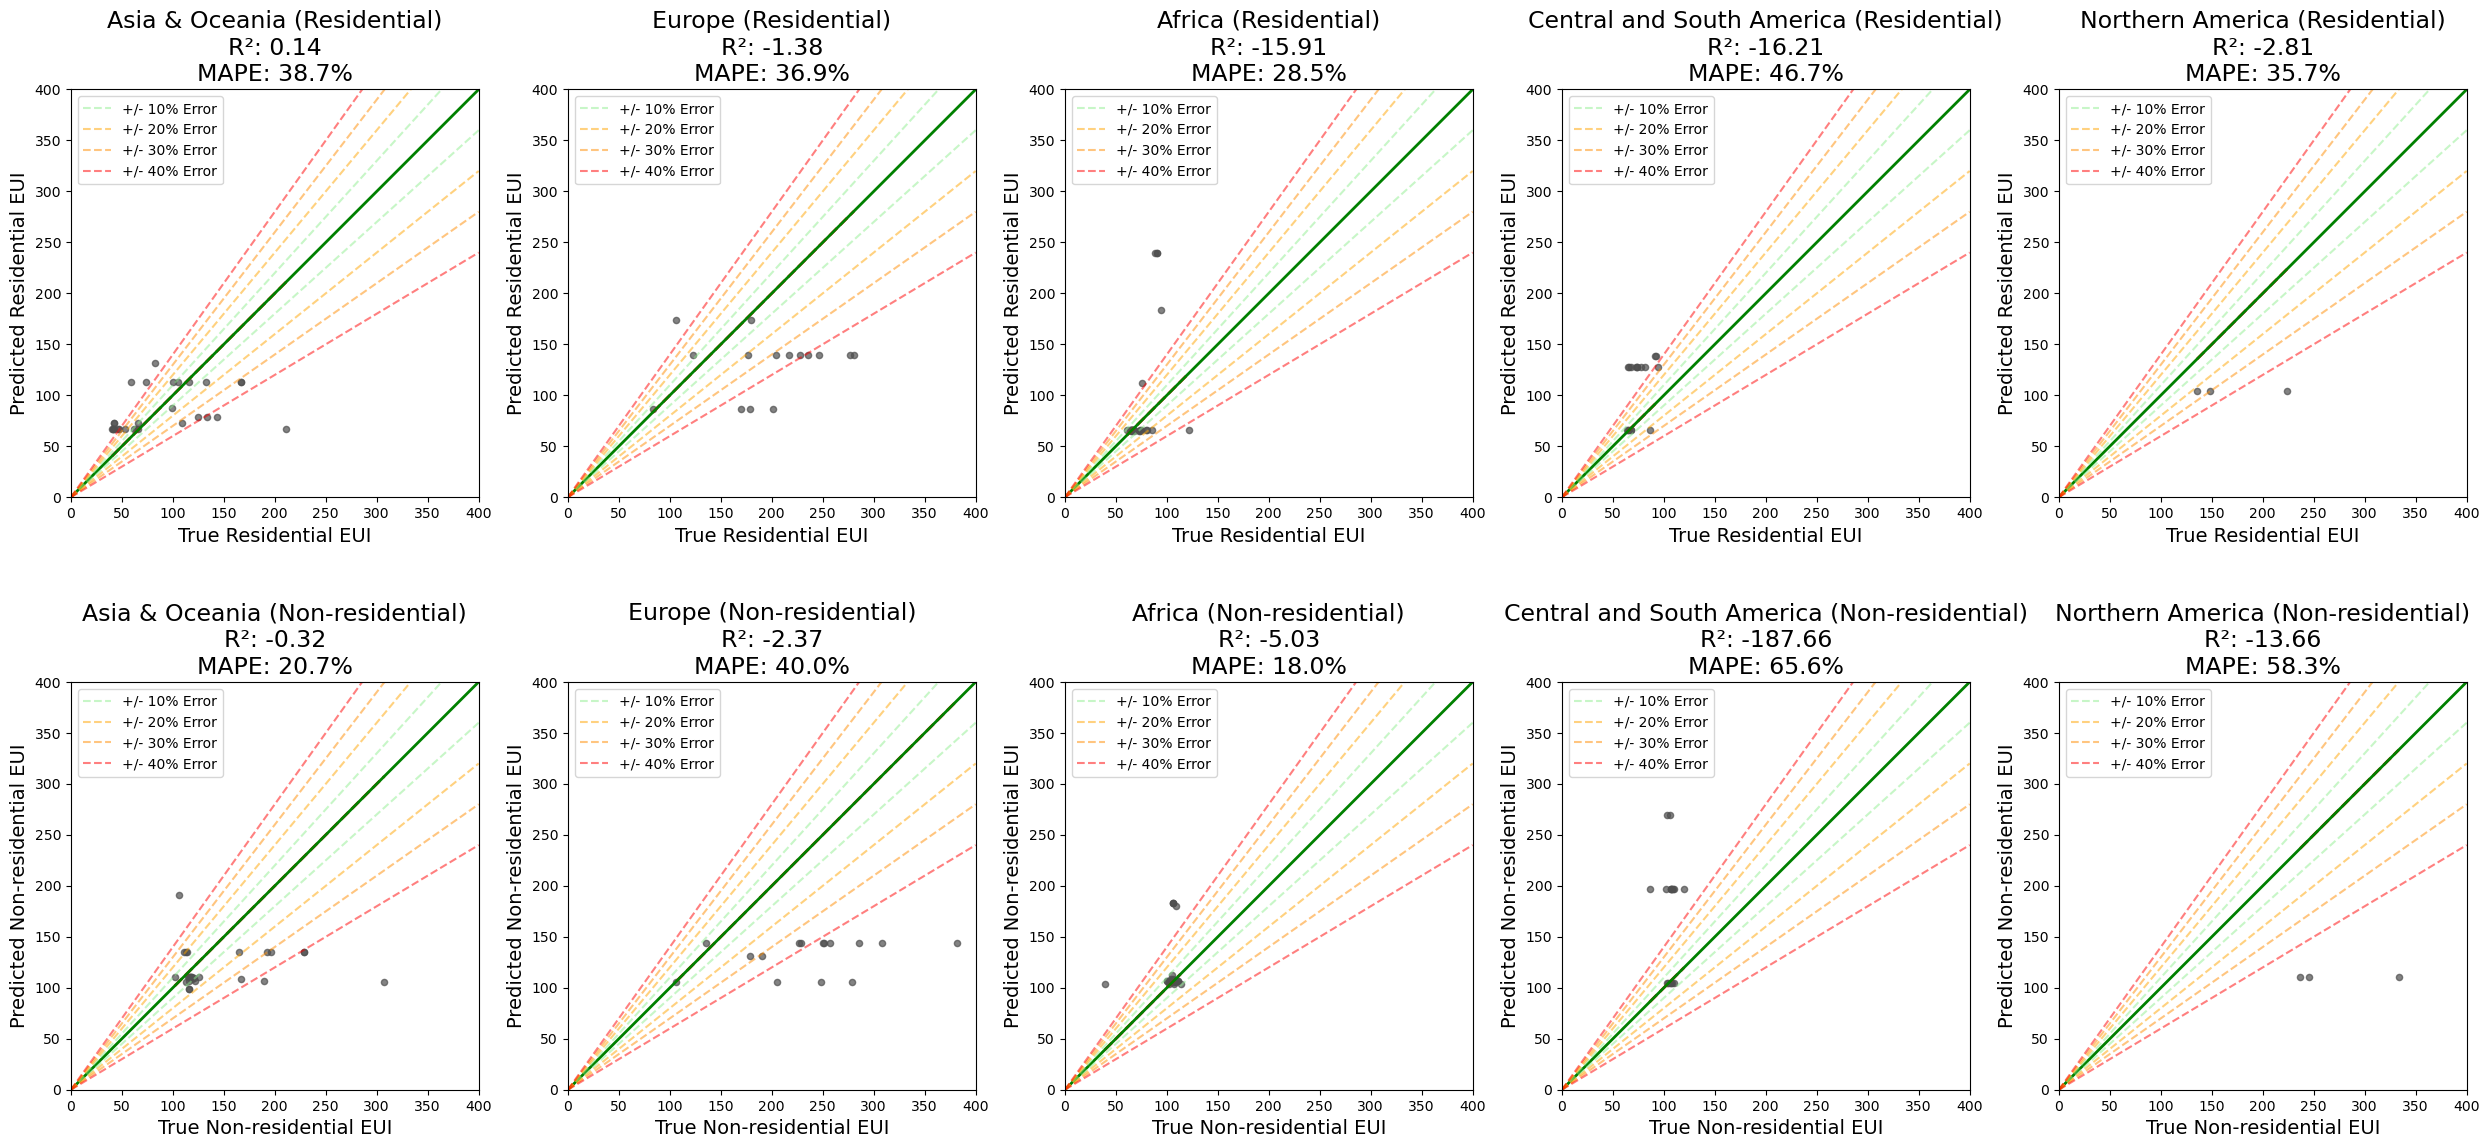

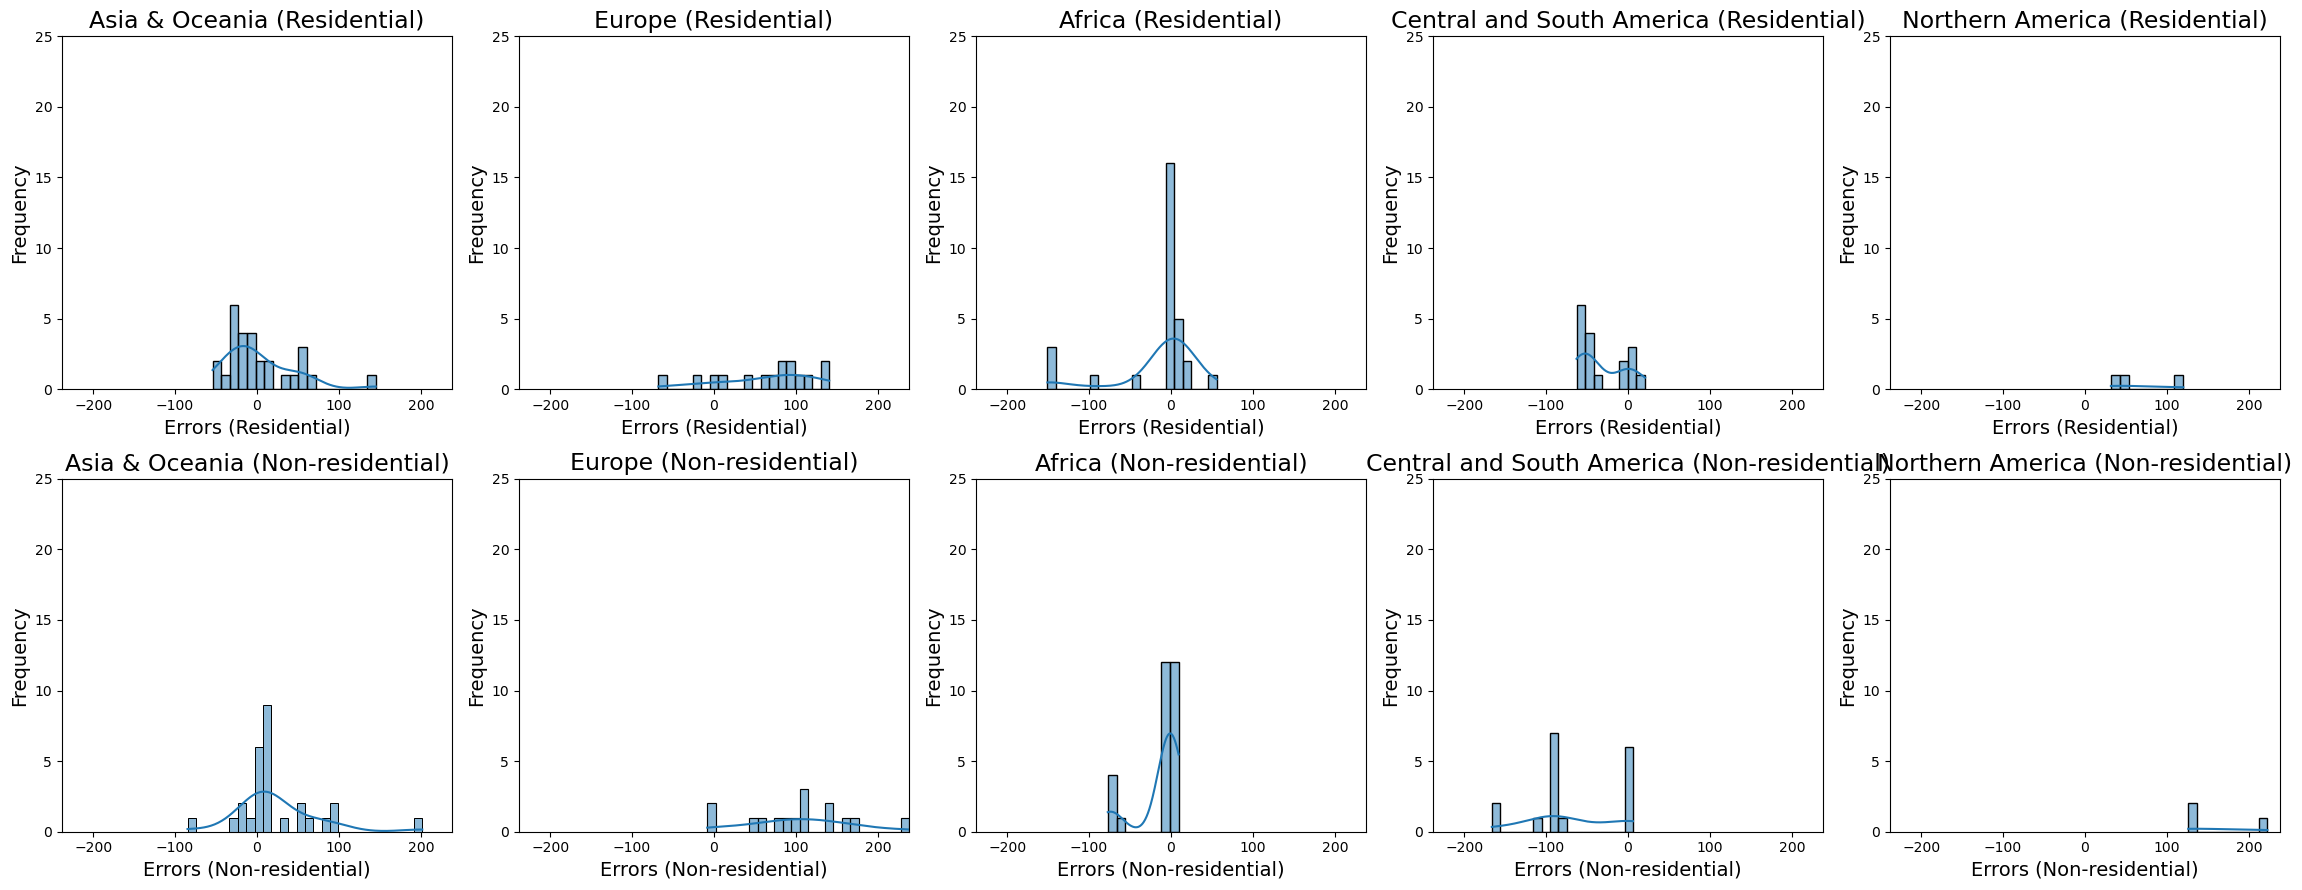

In [19]:
# Cross-domain
model_knn_cross = KNeighborsRegressor(**knn_params)
results_knn_cross = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_knn_cross,
    strategy='cross_domain'
)

create_eui_comparison_plots(results_knn_cross,
    save_path='../figures/model_plots/knn_cross_domain_eui_predictions.png')

create_error_distribution_plots(results_knn_cross,
    save_path='../figures/model_plots/knn_cross_domain_error_distribution.png')

### KNN - All Domain

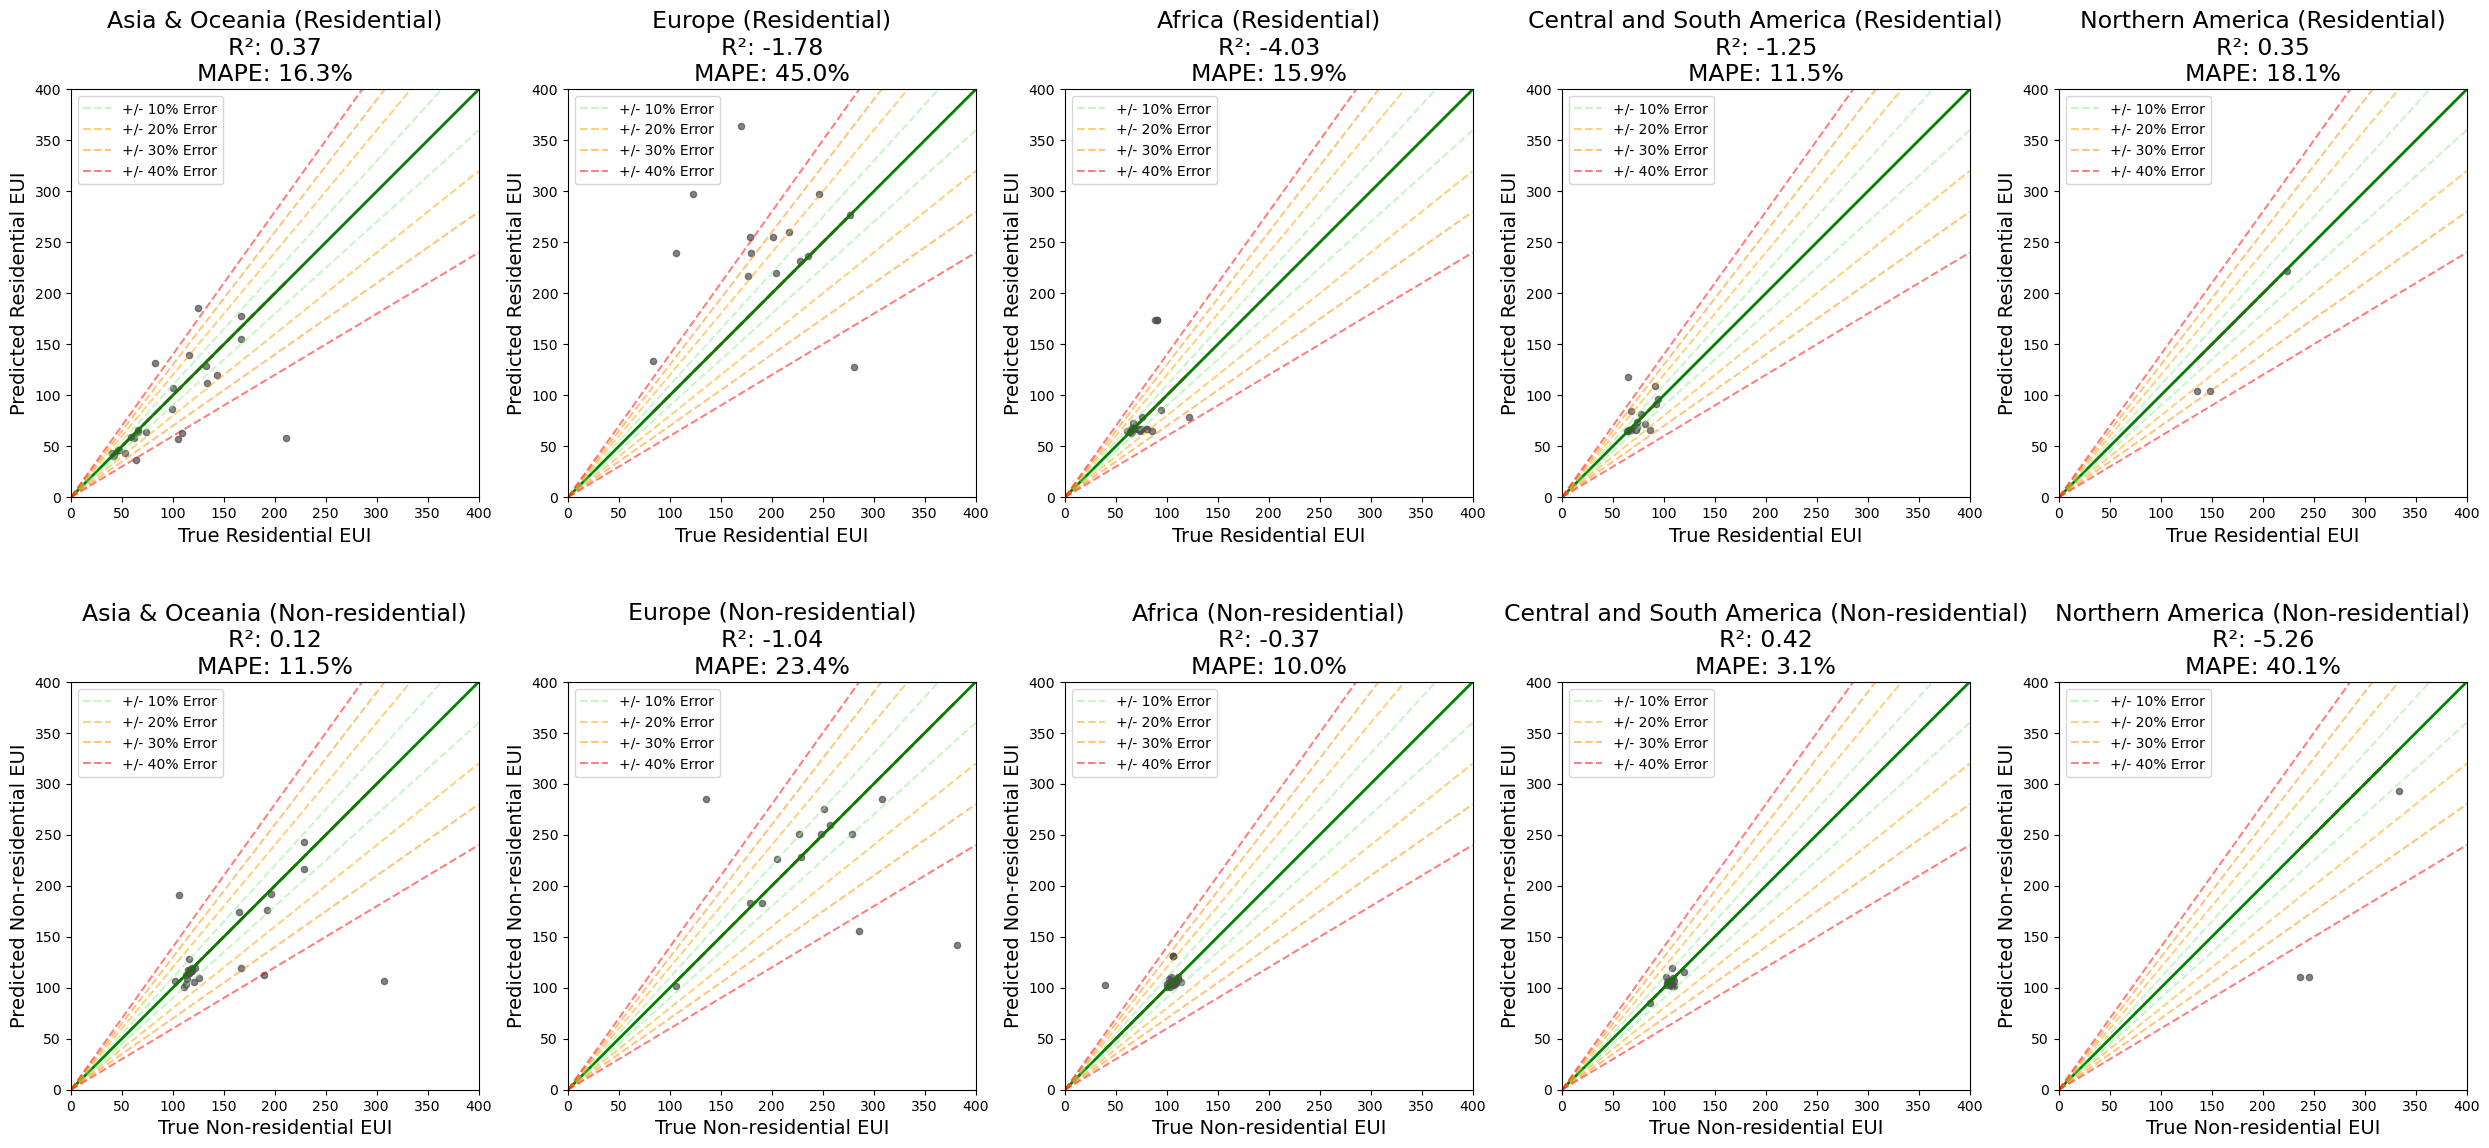

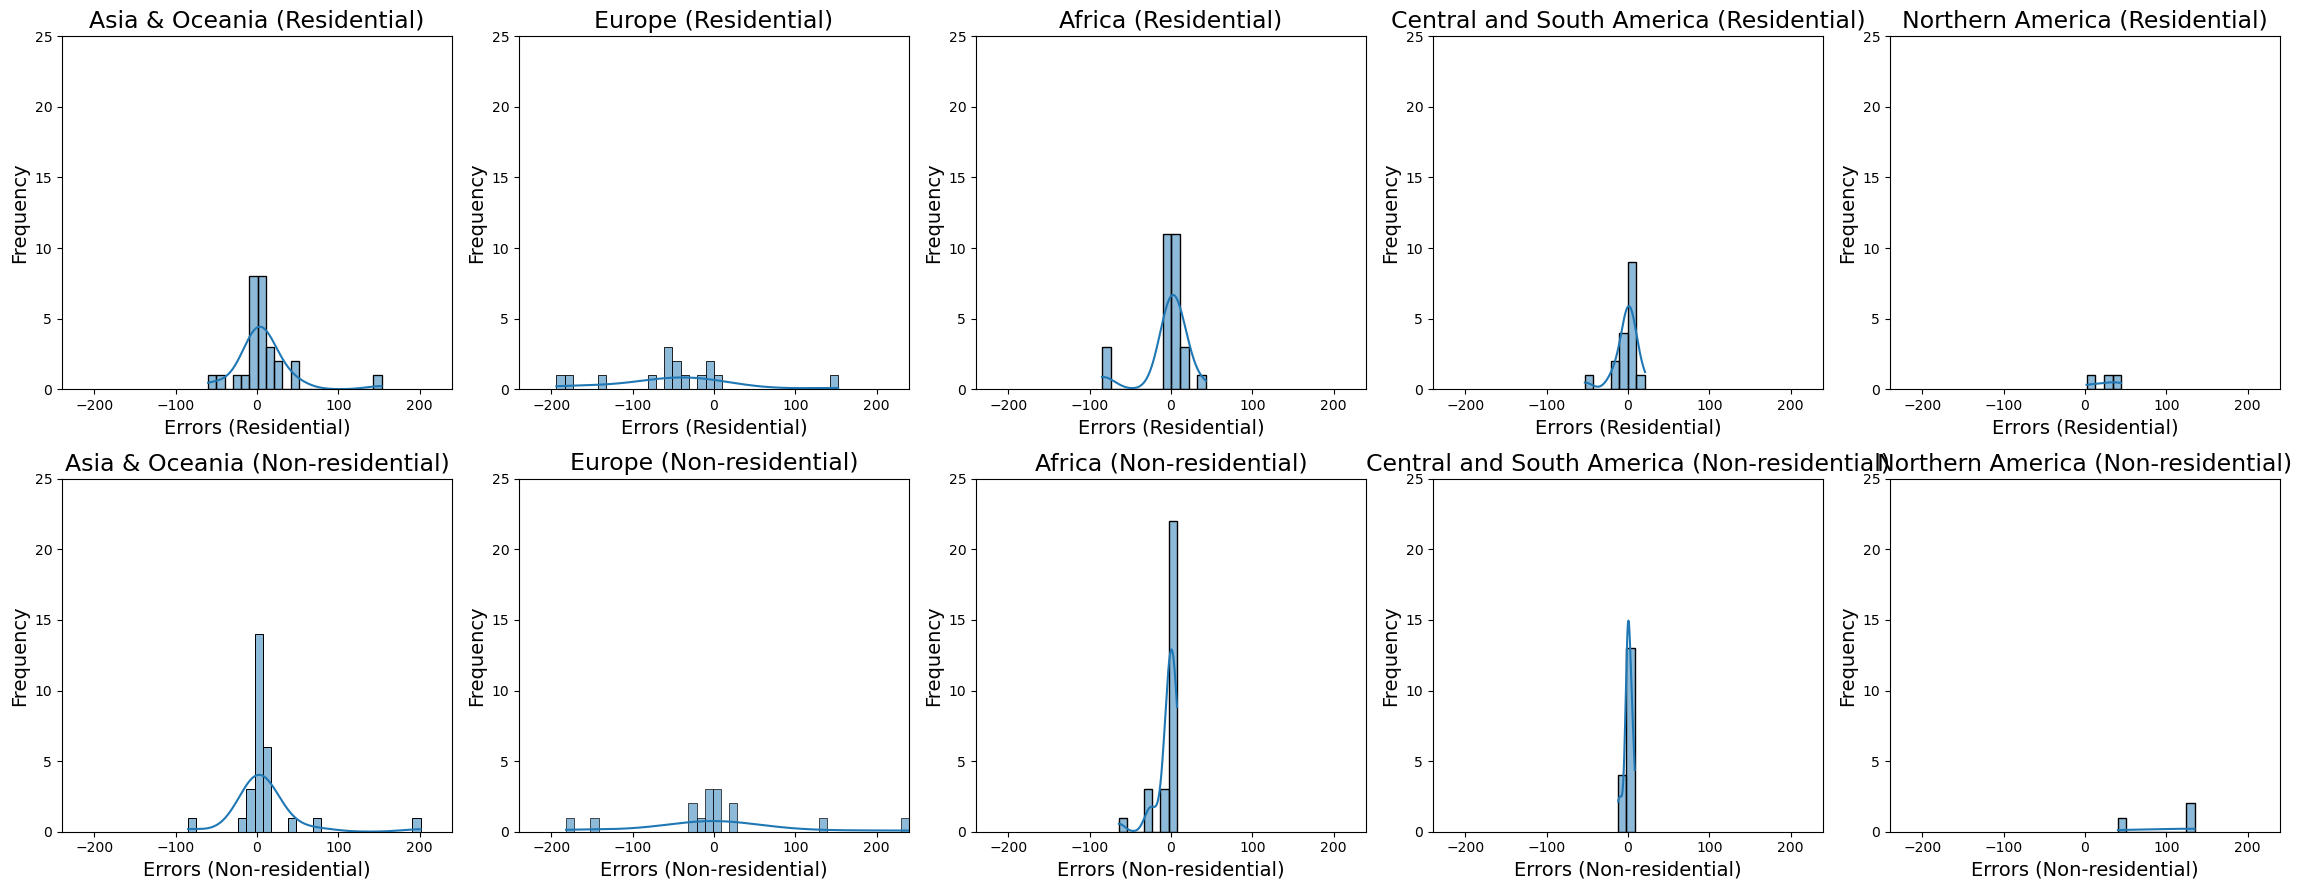

In [20]:
# All-domain
model_knn_all = KNeighborsRegressor(**knn_params)
results_knn_all = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_knn_all,
    strategy='all_domain'
)

create_eui_comparison_plots(results_knn_all,
    save_path='../figures/model_plots/knn_all_domain_eui_predictions.png')

create_error_distribution_plots(results_knn_all,
    save_path='../figures/model_plots/knn_all_domain_error_distribution.png'
    )

In [21]:
KNNModel = lambda: KNeighborsRegressor(**knn_params)

knn_detailed_results = evaluate_model_strategies(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model_type=KNNModel,  
    feature_abbreviations=feature_abbreviations,
    model_details= ", ".join(f"{k}={v}" for k, v in knn_params.items())
)

knn_detailed_results['Model'] = 'KNeighborsRegressor'
knn_average_results = calculate_average_metrics(knn_detailed_results).reset_index()
knn_average_results

,Target,Strategy,Model,Model Details,Features Used,Features Abbreviated,MAPE,R²,MSE,RMSE,MAE,WAPE
0,Non-residential EUI (kWh/m2/year),within_domain,KNeighborsRegressor,n_neighbors=1,"longitude_sin, longitude_cos, latitude_sin, la...",Long_Sin | Long_Cos | Lat_Sin | Lat_Cos,11.82,-0.086,2476.517,38.829,24.282,11.86
1,Non-residential EUI (kWh/m2/year),cross_domain,KNeighborsRegressor,n_neighbors=1,"longitude_sin, longitude_cos, latitude_sin, la...",Long_Sin | Long_Cos | Lat_Sin | Lat_Cos,40.52,-41.808,10835.735,92.350,76.988,41.60
2,Non-residential EUI (kWh/m2/year),all_domain,KNeighborsRegressor,n_neighbors=1,"longitude_sin, longitude_cos, latitude_sin, la...",Long_Sin | Long_Cos | Lat_Sin | Lat_Cos,17.62,-1.226,4612.428,53.630,37.339,16.88
3,Residential EUI (kWh/m2/year),within_domain,KNeighborsRegressor,n_neighbors=1,"longitude_sin, longitude_cos, latitude_sin, la...",Long_Sin | Long_Cos | Lat_Sin | Lat_Cos,18.28,-0.847,2223.548,36.371,24.073,17.90
4,Residential EUI (kWh/m2/year),cross_domain,KNeighborsRegressor,n_neighbors=1,"longitude_sin, longitude_cos, latitude_sin, la...",Long_Sin | Long_Cos | Lat_Sin | Lat_Cos,37.30,-7.235,3933.832,60.100,46.603,38.92
5,Residential EUI (kWh/m2/year),all_domain,KNeighborsRegressor,n_neighbors=1,"longitude_sin, longitude_cos, latitude_sin, la...",Long_Sin | Long_Cos | Lat_Sin | Lat_Cos,21.36,-1.270,2422.358,41.103,27.509,20.62


In [22]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
knn_detailed_results.to_csv(f'../results/{timestamp}_knn_detailed_results.csv')
knn_average_results.to_csv(f'../results/{timestamp}_knn_average_results.csv')

# 